# About this kernel

In this kernel, we will explore the complete workflow for the APTOS 2019 competition. We will go through:

1. Loading & Exploration: A quick overview of the dataset
2. Resize Images: We will resize both the training and test images to 224x224, so that it matches the ImageNet format.
3. Mixup & Data Generator: We show how to create a data generator that will perform random transformation to our datasets (flip vertically/horizontally, rotation, zooming). This will help our model generalize better to the data, since it is fairly small (only ~3000 images).
4. Quadratic Weighted Kappa: A thorough overview of the metric used for this competition, with an intuitive example. Check it out!
5. Model: We will use a DenseNet-121 pre-trained on ImageNet. We will finetune it using Adam for 15 epochs, and evaluate it on an unseen validation set.
6. Training & Evaluation: We take a look at the change in loss and QWK score through the epochs.

### Unused Methods

Throughout V15-V18 of this kernel, I ablated a few methods that I presented in this kernel. The highest LB score was achieved after I removed:
* Mixup
* Optimized Threshold

I decided to keep them in the kernel if it ever becomes useful for you.

### Citations & Resources

* I had the idea of using mixup from [KeepLearning's ResNet50 baseline](https://www.kaggle.com/mathormad/aptos-resnet50-baseline). Since the implementation was in PyTorch, I instead used an [open-sourced keras implementation](https://github.com/yu4u/mixup-generator).
* The transfer learning procedure is mostly inspired from my [previous kernel for iWildCam](https://www.kaggle.com/xhlulu/densenet-transfer-learning-iwildcam-2019). The workflow was however heavily modified since then.
* Used similar [method as Abhishek](https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa) to find the optimal threshold.
* [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets) prompted me to try using Multilabel instead of multiclass classification, which slightly improved the kappa score.

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

Set random seed for reproducibility.

In [2]:
np.random.seed(2019)
tf.random.set_seed(2019)

# Loading & Exploration

In [3]:
train_df = pd.read_csv('dataset_btp/train.csv')
test_df = pd.read_csv('dataset_btp/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

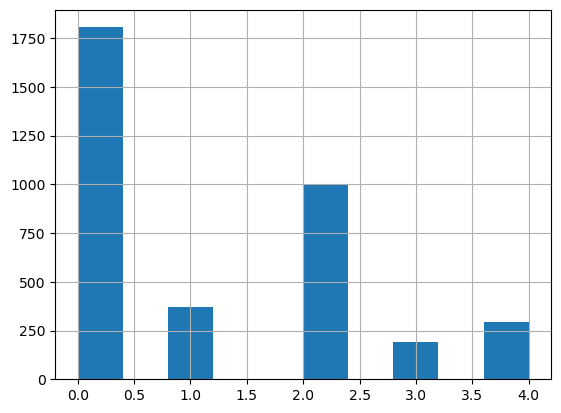

In [4]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

### Displaying some Sample Images

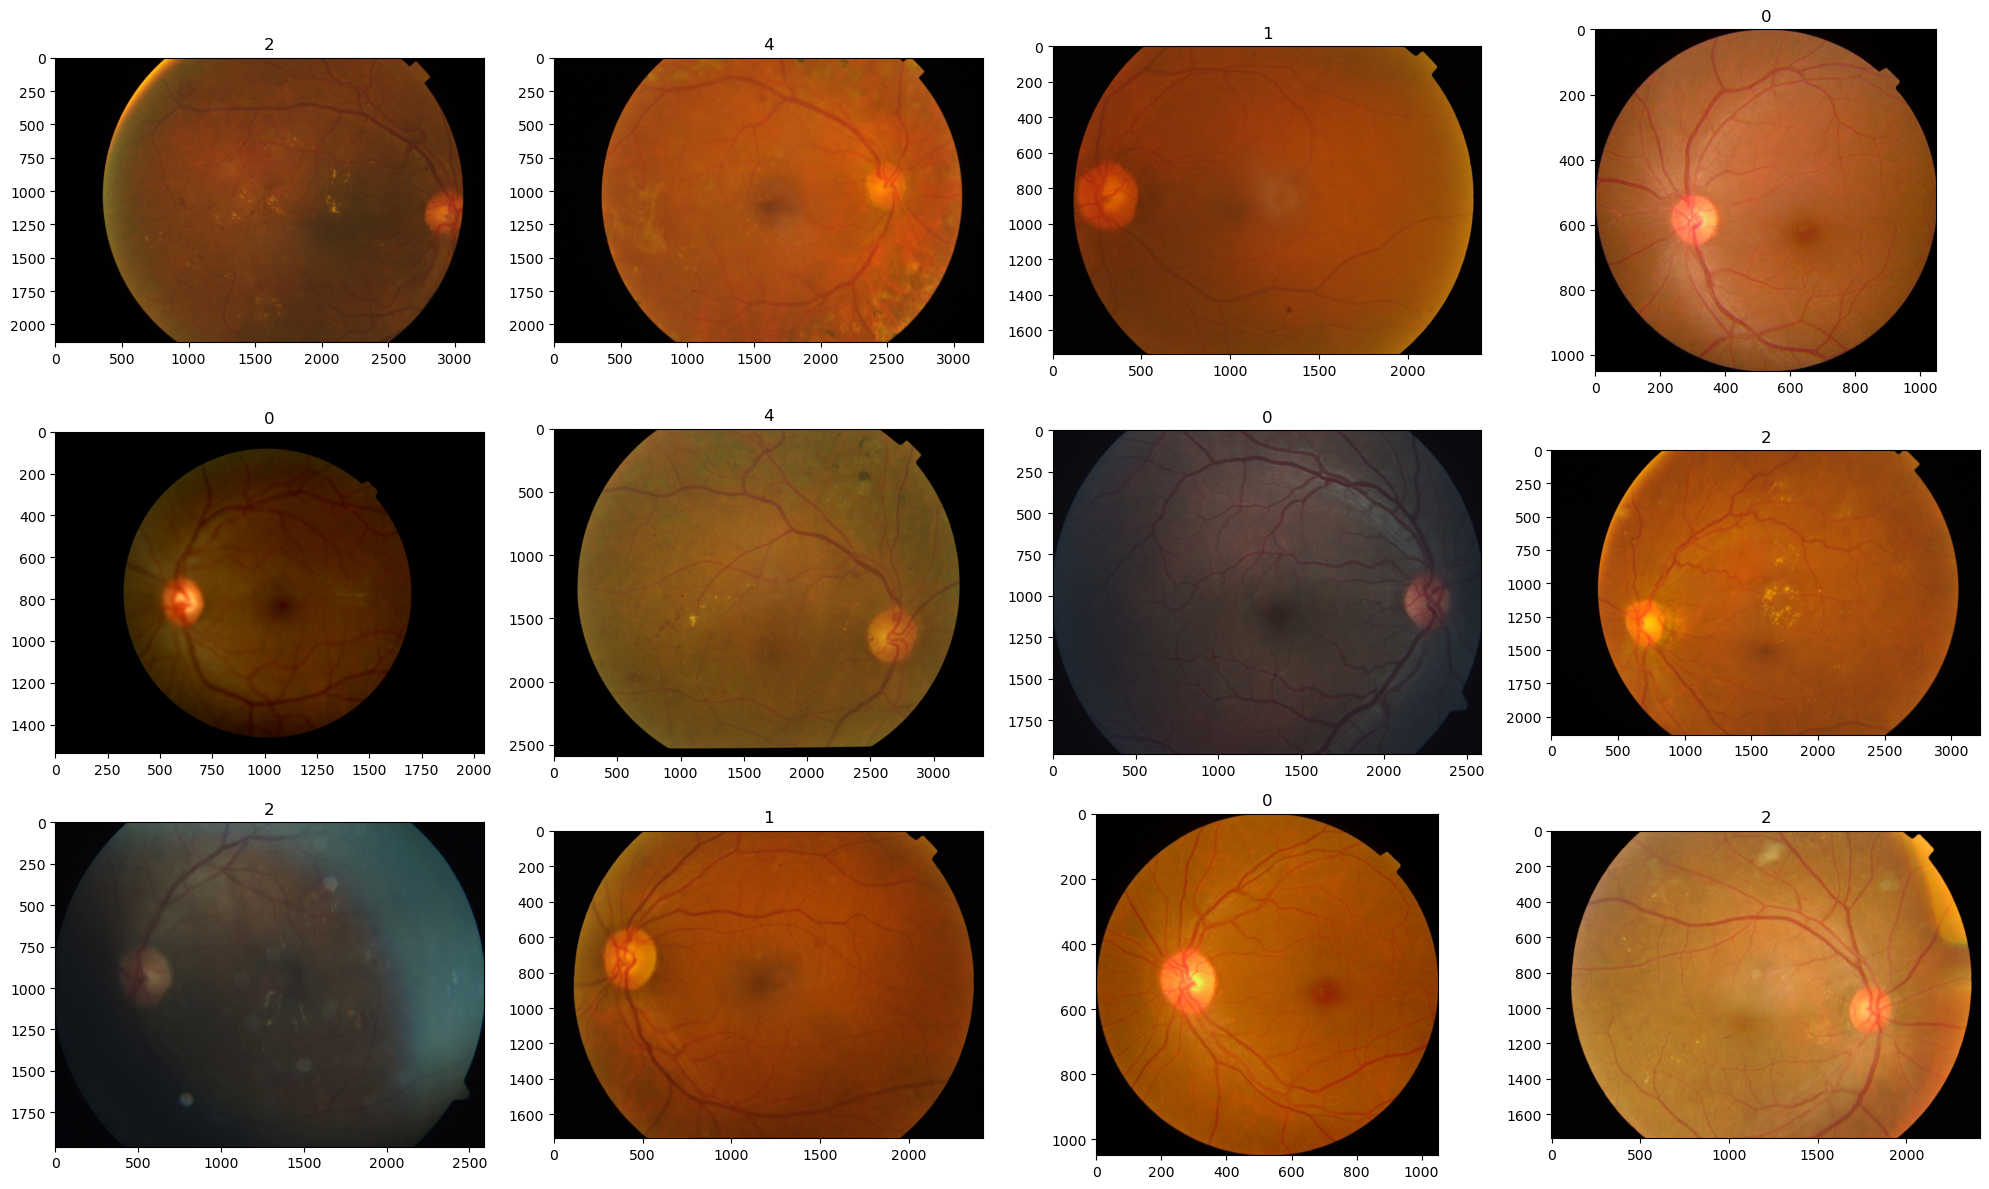

In [5]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'dataset_btp/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)

    plt.tight_layout()

display_samples(train_df)

# Resize Images

We will resize the images to 224x224, then create a single numpy array to hold the data.

In [6]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)

    return im

In [7]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'dataset_btp/train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [05:12<00:00, 11.70it/s]


In [10]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'dataset_btp/test_images/{image_id}.png'
    )

100%|██████████| 1928/1928 [00:51<00:00, 37.59it/s]


In [11]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


## Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. For more details, please check out [Lex's kernel](https://www.kaggle.com/lextoumbourou/blindness-detection-resnet34-ordinal-targets).

In [12]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


Now we can split it into a training and validation set.

In [13]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi,
    test_size=0.15,
    random_state=2019
)

# Mixup & Data Generator

Please Note: Although I show how to construct Mixup, **it is currently unused**. Please see notice at the top of the kernel.

In [14]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [29]:
BATCH_SIZE = 16

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)
# Using Mixup
mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

# Quadratic Weighted Kappa

Quadratic Weighted Kappa (QWK, the greek letter $\kappa$), also known as Cohen's Kappa, is the official evaluation metric. For our kernel, we will use a custom callback to monitor the score, and plot it at the end.

### What is Cohen Kappa?

According to the [wikipedia article](https://en.wikipedia.org/wiki/Cohen%27s_kappa), we have
> The definition of $\kappa$ is:
> $$\kappa \equiv \frac{p_o - p_e}{1 - p_e}$$
> where $p_o$ is the relative observed agreement among raters (identical to accuracy), and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly seeing each category.

### How is it computed?

Let's take the example of a binary classification problem. Say we have:

In [30]:
true_labels = np.array([1, 0, 1, 1, 0, 1])
pred_labels = np.array([1, 0, 0, 0, 0, 1])

We can construct the following table:

| true | pred | agreement      |
|------|------|----------------|
| 1    | 1    | true positive  |
| 0    | 0    | true negative  |
| 1    | 0    | false negative |
| 1    | 0    | false negative |
| 0    | 0    | true negative  |
| 1    | 1    | true positive  |


Then the "observed proportionate agreement" is calculated exactly the same way as accuracy:

$$
p_o = acc = \frac{tp + tn}{all} = {2 + 2}{6} = 0.66
$$

This can be confirmed using scikit-learn:

In [31]:
accuracy_score(true_labels, pred_labels)

0.6666666666666666

Additionally, we also need to compute `p_e`:

$$p_{yes} = \frac{tp + fp}{all} \frac{tp + fn}{all} = \frac{2}{6} \frac{4}{6} = 0.222$$

$$p_{no} = \frac{fn + tn}{all} \frac{fp + tn}{all} = \frac{4}{6} \frac{2}{6} = 0.222$$

$$p_{e} = p_{yes} + p_{no} = 0.222 + 0.222 = 0.444$$

Finally,

$$
\kappa = \frac{p_o - p_e}{1-p_e} = \frac{0.666 - 0.444}{1 - 0.444} = 0.4
$$

Let's verify with scikit-learn:

In [32]:
cohen_kappa_score(true_labels, pred_labels)

0.3999999999999999

### What is the weighted kappa?

The wikipedia page offer a very concise explanation:
> The weighted kappa allows disagreements to be weighted differently and is especially useful when **codes are ordered**. Three matrices are involved, the matrix of observed scores, the matrix of expected scores based on chance agreement, and the weight matrix. Weight matrix cells located on the diagonal (upper-left to bottom-right) represent agreement and thus contain zeros. Off-diagonal cells contain weights indicating the seriousness of that disagreement.

Simply put, if two scores disagree, then the penalty will depend on how far they are apart. That means that our score will be higher if (a) the real value is 4 but the model predicts a 3, and the score will be lower if (b) the model instead predicts a 0. This metric makes sense for this competition, since the labels 0-4 indicates how severe the illness is. Intuitively, a model that predicts a severe retinopathy (3) when it is in reality a proliferative retinopathy (4) is probably better than a model that predicts a mild retinopathy (1).

### Creating keras callback for QWK

In [33]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1

        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred,
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")

        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [34]:
class KappaMetrics(Callback):
    def __init__(self, validation_data=(), logs={}):
        super(Callback, self).__init__()
        self.validation_data = validation_data
        #print(validation_data)

    def on_epoch_end(self, epoch, logs={}):
        #print("Inside:", self.validation_data)
        X_val, y_val = self.validation_data[0:2]
        y_val = y_val.sum(axis=1) - 1

        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        logs['val_kappa'] = _val_kappa
        print(f"val_kappa: {_val_kappa:.4f}")

        return

# Model: DenseNet-121

In [35]:
densenet = DenseNet121(
    weights='dataset_btp/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [36]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )

    return model

In [37]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 7042629 (26.87 MB)
Trainable params: 6958981 (26.55 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


# Training & Evaluation

In [38]:
kappa_metrics =  KappaMetrics(validation_data=(x_val, y_val))

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

C:\Users\aygupta\AppData\Local\Temp\ipykernel_21544\994503353.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
18/18 [==============================] - 30s 2s/step- loss: 
val_kappa: 0.2787
194/194 [==============================] - 1025s 5s/step - loss: 0.2379 - accuracy: 0.8879 - val_loss: 1.0352 - val_accuracy: 0.9636 - val_kappa: 0.2787
Epoch 2/10
18/18 [==============================] - 30s 2s/step- loss: 0
val_kappa: 0.8410
194/194 [==============================] - 1022s 5s/step - loss: 0.1735 - accuracy: 0.8454 - val_loss: 0.1451 - val_accuracy: 0.9018 - val_kappa: 0.8410
Epoch 3/10
18/18 [==============================] - 30s 2s/step- loss: 0
val_kappa: 0.8108
194/194 [==============================] - 1027s 5s/step - loss: 0.1632 - accuracy: 0.8763 - val_loss: 0.2022 - val_accuracy: 0.7018 - val_kappa: 0.8108
Epoch 4/10
18/18 [==============================] - 31s 2s/step- loss: 0
val_kappa: 0.6885
194/194 [==============================] - 1043s 5s/step - loss: 0.1510 - accuracy: 0.8715 - val_loss: 0.3241 - val_accuracy: 0.9455 - val_kappa: 0.6885
Epoch 5/10
18/18 [=======

KeyboardInterrupt: 

<Axes: >

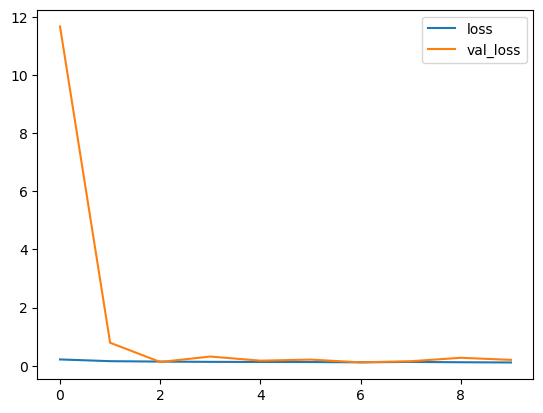

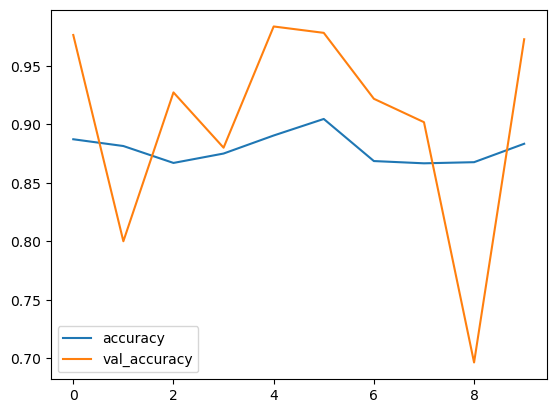

In [27]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [28]:
plt.plot(kappa_metrics.val_kappa)

AttributeError: 'KappaMetrics' object has no attribute 'val_kappas'

## Find best threshold

Please Note: Although I show how to construct a threshold optimizer, **it is currently unused**. Please see notice at the top of the kernel.

In [ ]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')

    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

## Submit

In [ ]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)